# Building a multilayer perceptron for classifying flowers in the Iris dataset

In [80]:
import torch
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [81]:
X = iris['data']
y = iris['target']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=11)

In [83]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train) # y_train not normalised, make a tensorDataset
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle = True) # make a dataloader

In [84]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self,x):
        x = self.layer1(x)
        x = torch.nn.Sigmoid()(x)
        x = self.layer2(x)
        x = torch.nn.Softmax(dim=1)(x)
        return x


In [85]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)

In [86]:
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [87]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl :
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step() # update weights
        optimizer.zero_grad() # zeroize weights

        loss_hist[epoch] += loss.item()
        is_correct = (torch.argmax(pred, dim=1) == y_batch ).float()
        accuracy_hist[epoch] += is_correct.mean()
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

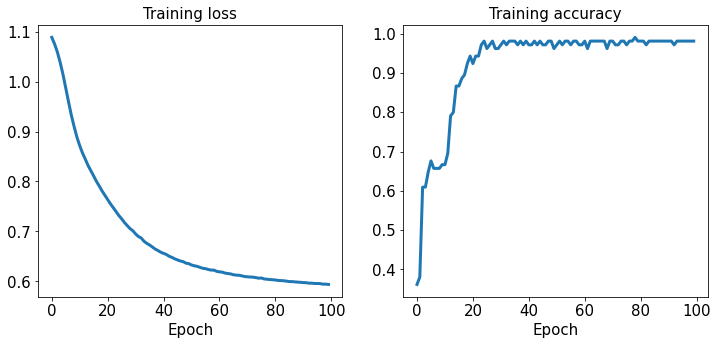

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### Evaluating the trained model on the test dataset

In [89]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train) # normalized with X_train
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9556


### Saving and reloading the trained model

In [90]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [91]:
model_new = torch.load(path)

In [92]:
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [93]:
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9556


If you want to save only the learned parameters, you can use `save(model.state_dict())` as follows:

In [94]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [95]:
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>